# Klasifikasi Penyakit Kulit Dengan Metode Gaussian Naive Bayes

## Business Understanding

### Tujuan Proyek

Masalah yang ingin dipecahkan:  
Diagnosis penyakit kulit sering kali membutuhkan keahlian medis dan waktu yang tidak sedikit. Dengan menggunakan model klasifikasi berbasis gambar, proses ini dapat dipercepat dan akurasi dapat ditingkatkan.

Tujuan Utama:  
Mengembangkan model klasifikasi otomatis untuk mendeteksi jenis penyakit kulit berdasarkan gambar.  
Meningkatkan efisiensi diagnosis untuk dokter dan tenaga medis.

### Manfaat Bisnis

1. Bagi Tenaga Medis (Dokter/Spesialis):  
Mempercepat proses diagnosis dengan memberikan second opinion berbasis model otomatis.  
Membantu dokter mengidentifikasi penyakit dengan lebih konsisten, terutama dalam kasus yang sulit.  
Mengurangi beban kerja dokter pada fasilitas kesehatan dengan pasien yang banyak.

2. Bagi Pasien:  
Meningkatkan akses ke diagnosis awal, terutama bagi pasien di daerah terpencil tanpa spesialis kulit.  
Membantu pasien memahami kondisi kulit mereka sebelum berkonsultasi langsung dengan dokter.

3. Bagi Institusi Kesehatan:  
Mengurangi waktu tunggu diagnosis di klinik dan rumah sakit.  
Membantu dalam program pencegahan dan edukasi kesehatan dengan menggunakan teknologi.


4. Bagi Peneliti atau Industri Teknologi:  
Memberikan dataset dan model yang dapat diadaptasi untuk berbagai penyakit kulit di masa depan.  
Memajukan penggunaan teknologi AI dalam bidang kesehatan.  


### KPI (Key Performance Indicators)

Akurasi Model: Berapa persentase diagnosis yang benar oleh model.  
Precision dan Recall: Kinerja untuk masing-masing kelas penyakit.   
Fleksibilitas Model: Kemampuan model menangani gambar dari berbagai kualitas atau sumber.

## Data Understanding

### Deskripsi Dataset

Kolom id_image:  
Tipe data: String atau file path.  
Deskripsi: Nama atau lokasi file gambar pada dataset.

Kolom dx:  
Tipe data: Kategorikal.  
Deskripsi: Label penyakit kulit berdasarkan diagnosis medis.

## Data Preparation

### Load Data

In [1]:
import pandas as pd

# Membaca DataSet
Data = pd.read_csv("C:/SEMESTER 5/BIGDATA/bigdata/Klasifikasi GNB/HAM10000_metadata.csv")
Data = Data.drop(columns=['lesion_id', 'dx_type', 'age','sex','localization'])
Data


,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


In [2]:
Data.shape

(10015, 2)

Dataset terdiri dari 10015 data dan 2 kolom yaitu :
- Image_id = Gambar lesi
- Dx = Diagnosis dari image_id

### Visualisasi Data

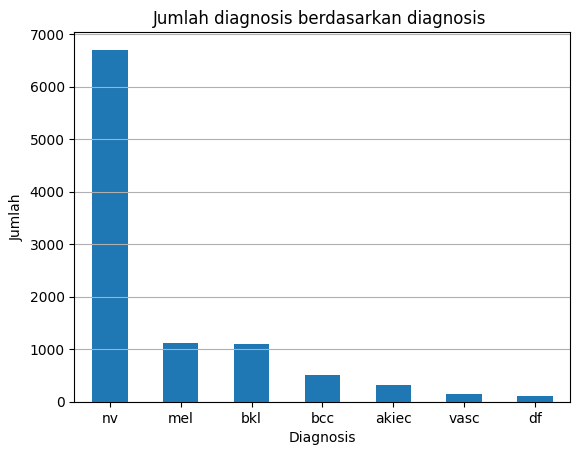

In [3]:
import matplotlib.pyplot as plt

# membuat grafik batang
Data['dx'].value_counts().plot.bar(rot=0)
plt.title('Jumlah diagnosis berdasarkan diagnosis ')
plt.xlabel('Diagnosis')
plt.ylabel('Jumlah')
plt.grid(axis='y')

In [4]:
# Mengetahui kelas unik
Class_dx = Data['dx'].unique()
Jumlah_classes = len(Class_dx)

print(f"Kelas dx: {Class_dx}")
print(f"Jumlah kelas: {Jumlah_classes}")

Kelas dx: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Jumlah kelas: 7


In [5]:
jumlah = Data['dx'].value_counts()
jumlah

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Terdapat 7 class pada dx yaitu ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
- **bkl** (Benign Keratosis Like Lesion) -> Lesi ini terlihat mirip dengan keratosis, biasanya merupakan lesi jinak yang dapat muncul sebagai bercak-bercak yang bersisik.
- **nv** (Nevus) -> tahi lalat berwarna coklat atau hitam
- **df** (Dermatofibroma) -> tumor jinak yang terbentuk dari sel-sel fibrosa dan sering muncul sebagai benjolan kecil di kulit.
- **mel** (Melanoma) -> jenis kanker kulit yang paling serius, yang berkembang dari sel-sel penghasil pigmen (melanosit).
- **vasc** (Vascular Lesions) -> Lesi ini berkaitan dengan pembuluh darah dan dapat termasuk kondisi seperti hemangioma (benjolan berwarna merah) atau telangiektasia (pembuluh darah yang melebar).
- **bcc** (Basal Cell Carcinoma) -> Ini adalah jenis kanker kulit yang paling umum dan berasal dari sel-sel basal di lapisan epidermis.
- **akiec** (Actinic Keratosis) -> lesi yang muncul pada kulit yang terpapar sinar matahari dan dapat berisiko berkembang menjadi kanker kulit. 

## Data Preprocessing

### Mencari Missing Value

In [6]:
import pandas as pd

# Memeriksa missing value
missing_values = Data.isnull().sum()

print("Jumlah misssing value setiap kolom:")
print(missing_values)

Jumlah misssing value setiap kolom:
image_id    0
dx          0
dtype: int64


### Mengecek Data Duplikat

In [7]:
# data duplikat berdasarkan 'lesion_id'
duplikat_lesion = Data.duplicated(subset='image_id')
jumlah_duplikat_lesion = duplikat_lesion.sum()
print(f"Jumlah data duplikat : {jumlah_duplikat_lesion}")

Jumlah data duplikat : 0


### Resize Data

In [8]:
import os
from PIL import Image

# Menentukan direktori tempat gambar berada
directories = [os.path.join("C:/SEMESTER 5/BIGDATA/bigdata/Klasifikasi GNB/HAM10000_images_part_1"),
               os.path.join("C:/SEMESTER 5/BIGDATA/bigdata/Klasifikasi GNB/HAM10000_images_part_2")]

# Mendapatkan ukuran gambar pertama sebagai ukuran referensi
reference_size = None
all_same_size = True

# Iterasi melalui semua direktori
for directory in directories:
    # Iterasi melalui semua file di direktori
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Memeriksa format gambar
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            
            if reference_size is None:
                reference_size = img.size
                
            if img.size != reference_size:
                all_same_size = False
                print(f"Gambar {filename} di {directory} tidak memiliki ukuran yang sama: {img.size}")

if all_same_size:
    print("Semua gambar memiliki ukuran yang sama:", reference_size)
else:
    print("Tidak semua gambar memiliki ukuran yang sama.")

Semua gambar memiliki ukuran yang sama: (600, 450)


## Data Processing

### Normalisasi Data

In [9]:
import numpy as np 

def normalize_image(image):
    # Mengubah gambar ke array NumPy
    img_array = np.array(image).astype('float32')
    # Normalisasi piksel ke rentang 0 hingga 1
    normalized_img = img_array / 255.0
    return normalized_img

# Iterasi melalui semua direktori
for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            
            # Normalisasi gambar
            normalized_img = normalize_image(img)

KeyboardInterrupt: 

### Augmentasi Data

Menyeimbangkan jumlah data per kelas menjadi 2000 data per kelas 

In [ ]:
import os
import pandas as pd
from PIL import Image, ImageOps
import random
import shutil

# Path ke file CSV yang berisi nama file gambar dan label
labels_csv = 'HAM10000_metadata.csv'

# Folder tempat gambar-gambar berada
image_folders = [
    os.path.join("C:/SEMESTER 5/BIGDATA/bigdata/Klasifikasi GNB/HAM10000_images_part_1"),
    os.path.join("C:/SEMESTER 5/BIGDATA/bigdata/Klasifikasi GNB/HAM10000_images_part_2")
]

# Folder tujuan untuk gambar yang sudah di-augmentasi
output_folder = 'Augmented'
os.makedirs(output_folder, exist_ok=True)

# Baca dataset
df = pd.read_csv(labels_csv)

# Jumlah target per kelas
target_sample_size = 2000

# Fungsi untuk menyalin gambar asli ke folder output
def copy_original_images(image_id, output_dir):
    for folder in image_folders:
        src_path = os.path.join(folder, image_id + '.jpg')
        if os.path.isfile(src_path):
            dest_path = os.path.join(output_dir, image_id + '.jpg')
            if not os.path.isfile(dest_path):  # Salin hanya jika belum ada
                shutil.copy(src_path, dest_path)
            return True
    return False

# Fungsi untuk augmentasi gambar
def augment_image(image_path, output_dir, image_id, augment_count):
    image = Image.open(image_path)
    augmented_images = []
    
    for i in range(augment_count):
        # Pilih transformasi augmentasi secara acak
        transform = random.choice(['flip', 'rotate', 'mirror', 'color'])
        
        if transform == 'flip':
            augmented = image.transpose(Image.FLIP_LEFT_RIGHT)
        elif transform == 'rotate':
            angle = random.randint(-30, 30)
            augmented = image.rotate(angle)
        elif transform == 'mirror':
            augmented = ImageOps.mirror(image)
        elif transform == 'color':
            augmented = ImageOps.autocontrast(image)
        
        # Simpan augmented image
        augmented_filename = f"{image_id}_aug_{i}.jpg"
        augmented.save(os.path.join(output_dir, augmented_filename))
        augmented_images.append(augmented_filename)
    
    return augmented_images

# Augmentasi dan sampling per kelas
final_data = []
for class_name in df['dx'].unique():
    class_images = df[df['dx'] == class_name]['image_id'].tolist()
    
    # Salin gambar asli ke folder output
    for img_id in class_images:
        copy_original_images(img_id, output_folder)
    
    # Kumpulkan semua gambar dalam kelas ini
    available_images = [img for img in os.listdir(output_folder) if img.startswith(tuple(class_images))]
    current_count = len(available_images)
    
    # Jika kurang, lakukan augmentasi
    if current_count < target_sample_size:
        print(f"Kelas '{class_name}' memiliki {current_count} gambar. Melakukan augmentasi tambahan.")
        augment_count = target_sample_size - current_count
        for img_id in class_images:
            src_path = os.path.join(output_folder, img_id + '.jpg')
            if os.path.isfile(src_path):
                augmented_images = augment_image(src_path, output_folder, img_id, augment_count)
                available_images.extend(augmented_images)
                augment_count -= len(augmented_images)
                if augment_count <= 0:
                    break
    
    # Jika lebih dari target, lakukan sampling
    sampled_images = random.sample(available_images, target_sample_size)
    
    # Simpan data ke final_data
    for img_file in sampled_images:
        img_id = os.path.splitext(img_file)[0]
        final_data.append({'image_id': img_id, 'dx': class_name})

# Simpan hasil ke CSV
final_df = pd.DataFrame(final_data)
output_csv = 'final_dataset.csv'
final_df.to_csv(output_csv, index=False)

print("Proses sampling selesai. Dataset dengan 2000 gambar per kelas disimpan di 'final_dataset.csv'.")

# Sinkronisasi folder Augmented dengan file final_dataset.csv
print("Sinkronisasi folder Augmented dengan final_dataset.csv...")
valid_images = set(final_df['image_id'] + '.jpg')

# Hapus gambar yang tidak ada di final_dataset.csv
for img_file in os.listdir(output_folder):
    if img_file not in valid_images:
        os.remove(os.path.join(output_folder, img_file))

print(f"Folder Augmented telah disinkronkan. Berisi {len(valid_images)} gambar yang sesuai dengan final_dataset.csv.")


Kelas 'bkl' memiliki 1099 gambar. Melakukan augmentasi tambahan.
Kelas 'df' memiliki 115 gambar. Melakukan augmentasi tambahan.
Kelas 'mel' memiliki 1113 gambar. Melakukan augmentasi tambahan.
Kelas 'vasc' memiliki 142 gambar. Melakukan augmentasi tambahan.
Kelas 'bcc' memiliki 514 gambar. Melakukan augmentasi tambahan.
Kelas 'akiec' memiliki 327 gambar. Melakukan augmentasi tambahan.
Proses sampling selesai. Dataset dengan 2000 gambar per kelas disimpan di 'final_dataset.csv'.
Sinkronisasi folder Augmented dengan final_dataset.csv...
Folder Augmented telah disinkronkan. Berisi 14000 gambar yang sesuai dengan final_dataset.csv.


### Menghitung Data Setelah Augmentasi

In [11]:
# Menghitung jumlah data per kelas setelah augmentasi
augmented_data_df = pd.DataFrame(final_data)

# Menghitung jumlah gambar per kelas setelah augmentasi
jumlah_after_augmentation = augmented_data_df['dx'].value_counts()

# Menampilkan hasil
print("Jumlah data setelah augmentasi:")
print(jumlah_after_augmentation)

Jumlah data setelah augmentasi:
dx
bkl      2000
nv       2000
df       2000
mel      2000
vasc     2000
bcc      2000
akiec    2000
Name: count, dtype: int64


### Ekstraksi Fitur PCA

In [ ]:
import os
import pandas as pd
import numpy as np
from skimage import io, color
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Folder tempat gambar hasil augmented berada
image_folder = 'C:/SEMESTER 5/BIGDATA/bigdata/Klasifikasi GNB/Augmented'

# File CSV hasil augmented
augmented_csv = 'C:/SEMESTER 5/BIGDATA/bigdata/Klasifikasi GNB/final_dataset.csv'

# Membaca data dari CSV
augmented_df = pd.read_csv(augmented_csv)

# Fungsi untuk preprocessing gambar
def process_image(image_path, size=(128, 128)):
    image = io.imread(image_path)
    hsv_image = color.rgb2hsv(image)  # Konversi ke HSV
    resized_image = resize(hsv_image, size, anti_aliasing=True)
    return resized_image

# Fungsi untuk ekstraksi fitur HSV
def extract_hsv_features(image):
    h_channel = image[:, :, 0]
    s_channel = image[:, :, 1]
    v_channel = image[:, :, 2]
    
    # Hitung statistik dasar untuk setiap channel
    h_mean, h_std = h_channel.mean(), h_channel.std()
    s_mean, s_std = s_channel.mean(), s_channel.std()
    v_mean, v_std = v_channel.mean(), v_channel.std()
    
    # Gabungkan fitur
    features = [h_mean, h_std, s_mean, s_std, v_mean, v_std]
    return features

# List untuk menyimpan fitur dan label
feature_list = []
label_list = []
image_ids = []

# Ekstraksi fitur dari setiap gambar
for index, row in augmented_df.iterrows():
    img_path = os.path.join(image_folder, row['image_id'] + '.jpg')
    
    if not os.path.isfile(img_path):
        print(f"File gambar tidak ditemukan: {img_path}")
        continue

    try:
        # Preprocessing gambar
        processed_image = process_image(img_path)

        # Ekstraksi fitur
        features = extract_hsv_features(processed_image)

        # Simpan fitur dan label
        feature_list.append(features)
        label_list.append(row['dx'])
        image_ids.append(row['image_id'])
    except Exception as e:
        print(f"Terjadi kesalahan saat memproses {img_path}: {e}")

# Konversi ke array NumPy
features = np.array(feature_list)
labels = np.array(label_list)

# Standardisasi fitur
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split data
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    features, labels, image_ids, test_size=0.2, random_state=42
)

# PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Analisis explained variance ratio
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Jumlah komponen untuk 95% varians: {optimal_components}")

# Terapkan PCA dengan jumlah komponen optimal
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Simpan hasil PCA ke DataFrame
train_pca_features = pd.DataFrame({
    'image_id': id_train,
    'dx': y_train,
    'pca_features': [x.tolist() for x in X_train_pca]
})

test_pca_features = pd.DataFrame({
    'image_id': id_test,
    'dx': y_test,
    'pca_features': [x.tolist() for x in X_test_pca]
})

# Simpan ke CSV
train_pca_output_csv = 'pca_features_train.csv'
test_pca_output_csv = 'pca_features_test.csv'

train_pca_features.to_csv(train_pca_output_csv, index=False)
test_pca_features.to_csv(test_pca_output_csv, index=False)

print("Ekstraksi fitur PCA selesai.")
print(f"Hasil PCA disimpan ke {train_pca_output_csv} dan {test_pca_output_csv}.")
print(f"Bentuk X_train_pca: {X_train_pca.shape}")
print(f"Bentuk X_test_pca: {X_test_pca.shape}")


Jumlah komponen untuk 95% varians: 6
Ekstraksi fitur PCA selesai.
Hasil PCA disimpan ke pca_features_train.csv dan pca_features_test.csv.
Bentuk X_train_pca: (11200, 6)
Bentuk X_test_pca: (2800, 6)


mereduksi dimensi dan mempertahankan 6 komponen 

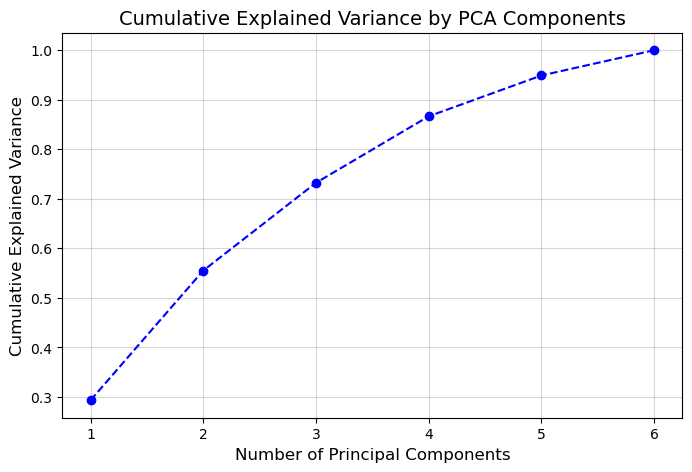

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.title("Cumulative Explained Variance by PCA Components", fontsize=14)
plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)
plt.grid(alpha=0.5)
plt.show()


### Modelling

melatih model dan evaluasi model

Akurasi: 73.57 %
Laporan Klasifikasi:
               precision    recall  f1-score   support

       akiec       0.76      0.86      0.81       393
         bcc       0.71      0.76      0.73       386
         bkl       0.59      0.70      0.64       407
          df       0.97      0.90      0.93       402
         mel       0.61      0.52      0.56       396
          nv       0.64      0.68      0.66       398
        vasc       0.94      0.75      0.83       418

    accuracy                           0.74      2800
   macro avg       0.75      0.74      0.74      2800
weighted avg       0.75      0.74      0.74      2800



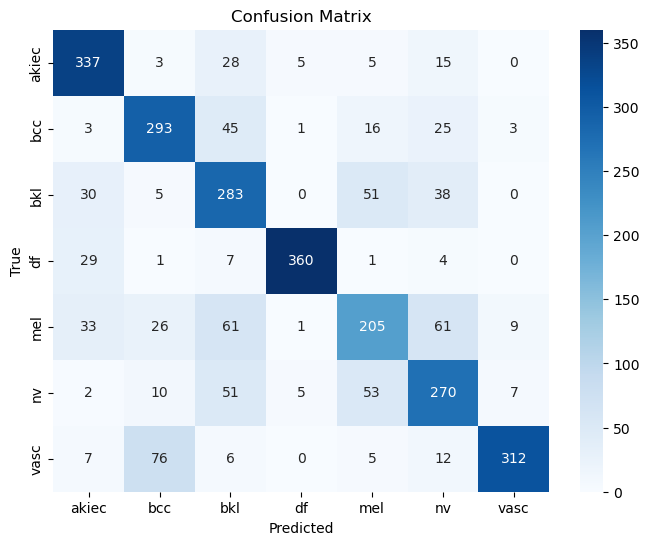

In [ ]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import streamlit as st

# Membaca data latih dan data uji
train_df = pd.read_csv('C:/SEMESTER 5/BIGDATA/bigdata/Klasifikasi GNB/pca_features_train.csv')
test_df = pd.read_csv('C:/SEMESTER 5/BIGDATA/bigdata/Klasifikasi GNB/pca_features_test.csv')

# Encode label target
label_encoder = LabelEncoder()
train_df['dx_encoded'] = label_encoder.fit_transform(train_df['dx'])
test_df['dx_encoded'] = label_encoder.transform(test_df['dx'])

# Siapkan fitur dan target untuk data latih
X_train = np.vstack(train_df['pca_features'].apply(eval).apply(np.array).values)
y_train = train_df['dx_encoded'].values

# Siapkan fitur dan target untuk data uji
X_test = np.vstack(test_df['pca_features'].apply(eval).apply(np.array).values)
y_test = test_df['dx_encoded'].values

# Buat dan latih model Gaussian Naive Bayes
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Prediksi
y_pred = gnb_model.predict(X_test)

# Evaluasi model
print(f"Akurasi: {round(accuracy_score(y_test, y_pred) * 100, 2)} %")
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


# Menghitung laporan klasifikasi (precision, recall, f1-score)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Menghitung confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Menampilkan hasil di Jupyter Notebook
import matplotlib.pyplot as plt



# Tampilkan confusion matrix sebagai heatmap untuk visualisasi
plt.figure(figsize=(8,6))
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()